Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import rdflib
from rdflib import Graph, Literal, Namespace, RDF, URIRef, OWL
from rdflib.extras.external_graph_libs import rdflib_to_networkx_digraph
from rdflib.namespace import DC, FOAF

from owlready2 import *
from owlready2 import get_ontology

from sklearn.model_selection import train_test_split

import networkx as nx
import networkx.algorithms.community as nx_comm

from sklearn.decomposition import PCA
import seaborn as sns
from adjustText import adjust_text
%matplotlib inline

random.seed(10)

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


Loading the triples

In [2]:
# load csv medsur.csv
colnames = ["subject", "predicate", "object"]
triples_df = pd.read_csv('medsur.csv', names=colnames, header=None) 
triples_df['object'] = triples_df['object'].str.rstrip()

print(triples_df.head())

                                             subject  \
0  http://www.medsur.org/patient_NLGRUNENTHAL2018...   
1           http://www.medsur.org/patient_NLLRB30683   
2           http://www.medsur.org/patient_NLLRB34229   
3          http://www.medsur.org/patient_NLLRB187444   
4           http://www.medsur.org/patient_NLLRB18477   

                                         predicate  \
0  http://example.org/medsur.rdf#suffersSideEffect   
1  http://example.org/medsur.rdf#suffersSideEffect   
2  http://example.org/medsur.rdf#suffersSideEffect   
3  http://example.org/medsur.rdf#suffersSideEffect   
4  http://example.org/medsur.rdf#suffersSideEffect   

                                       object  
0  http://www.medsur.org/side_effect/10053198  
1  http://www.medsur.org/side_effect/10007697  
2  http://www.medsur.org/side_effect/10008479  
3  http://www.medsur.org/side_effect/10014080  
4  http://www.medsur.org/side_effect/10002855  


Filter triples to get symptoms (and side effects)

In [3]:
# only select triples that contains the predicate 'suffersSideEffect'
triples_df = triples_df[(triples_df['predicate'] == 'http://example.org/medsur.rdf#hasSymptom') | (triples_df['predicate'] == 'http://example.org/medsur.rdf#suffersSideEffect')]
print(triples_df.head())

                                             subject  \
0  http://www.medsur.org/patient_NLGRUNENTHAL2018...   
1           http://www.medsur.org/patient_NLLRB30683   
2           http://www.medsur.org/patient_NLLRB34229   
3          http://www.medsur.org/patient_NLLRB187444   
4           http://www.medsur.org/patient_NLLRB18477   

                                         predicate  \
0  http://example.org/medsur.rdf#suffersSideEffect   
1  http://example.org/medsur.rdf#suffersSideEffect   
2  http://example.org/medsur.rdf#suffersSideEffect   
3  http://example.org/medsur.rdf#suffersSideEffect   
4  http://example.org/medsur.rdf#suffersSideEffect   

                                       object  
0  http://www.medsur.org/side_effect/10053198  
1  http://www.medsur.org/side_effect/10007697  
2  http://www.medsur.org/side_effect/10008479  
3  http://www.medsur.org/side_effect/10014080  
4  http://www.medsur.org/side_effect/10002855  


In [4]:
triples_df.predicate.unique() # looks correct

array(['http://example.org/medsur.rdf#suffersSideEffect',
       'http://example.org/medsur.rdf#hasSymptom'], dtype=object)

Create entities

In [5]:
# create np array of triples [[row1], [row2], ...]
triples = triples_df.values
triples[0] # looks correct

entities = np.unique(np.concatenate([triples[:, 0], triples[:, 2]]))
entities

array(['http://www.medsur.org/patient_CFNL09249',
       'http://www.medsur.org/patient_ESKYOWAKIRIN2019BKK009955',
       'http://www.medsur.org/patient_GBConsilientHealthCONSIL20201202846',
       ..., 'http://www.medsur.org/symptom/10084427',
       'http://www.medsur.org/symptom/10085423',
       'http://www.medsur.org/symptom/10085637'], dtype=object)

Train-test split

In [6]:
from ampligraph.evaluation import train_test_split_no_unseen

test_size = int(0.2*len(triples_df))

X_train, X_test = train_test_split_no_unseen(triples, test_size=test_size)

print('Train set size: ', X_train.shape)
print('Test set size: ', X_test.shape)

Train set size:  (835917, 3)
Test set size:  (208979, 3)


We choose ComplEx as our Knowledge Graph Embedding model:

In [7]:
from ampligraph.latent_features.models import ScoringBasedEmbeddingModel
    
# Initialize a ComplEx neural embedding model: the embedding size is k,
# eta specifies the number of corruptions to generate per each positive,
# scoring_type determines the scoring function of the embedding model.
model = ScoringBasedEmbeddingModel(k=150,
                                   eta=10,
                                   scoring_type='ComplEx')

Compile model

In [8]:
import tensorflow as tf

from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer

# Optimizer, loss and regularizer definition
optim = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = get_loss('pairwise', {'margin': 0.5})
regularizer = get_regularizer('LP', {'p': 2, 'lambda': 1e-5})

# Compilation of the model
model.compile(loss=loss,
              optimizer='adam',
              entity_relation_regularizer=regularizer,
              entity_relation_initializer='glorot_uniform')

Train model

In [9]:
# Fit the model on training and validation set

history = model.fit(X_train,
          batch_size=int(X_train.shape[0] / 10), # use 1/10 of the training set as batch size
          epochs=100,                    # Number of training epochs
          verbose=True                  # Enable stdout messages
          )

Epoch 1/100
12/12 [==============================] - 65s 5s/step - loss: 379891.8125
Epoch 2/100
12/12 [==============================] - 64s 5s/step - loss: 378876.9688
Epoch 3/100
12/12 [==============================] - 66s 6s/step - loss: 375243.6875
Epoch 4/100
12/12 [==============================] - 67s 6s/step - loss: 366568.9688
Epoch 5/100
12/12 [==============================] - 60s 5s/step - loss: 349815.7188
Epoch 6/100
12/12 [==============================] - 57s 5s/step - loss: 321496.4062
Epoch 7/100
12/12 [==============================] - 61s 5s/step - loss: 290360.1250
Epoch 8/100
12/12 [==============================] - 62s 5s/step - loss: 264735.4688
Epoch 9/100
12/12 [==============================] - 60s 5s/step - loss: 244093.1094
Epoch 10/100
12/12 [==============================] - 59s 5s/step - loss: 226869.5938
Epoch 11/100
12/12 [==============================] - 57s 5s/step - loss: 212089.7969
Epoch 12/100
12/12 [==============================] - 55s 5s/st

An additional step when evaluating KGEs: Define a filter so that no negative statements generated by the corruption procedure are actually positives.

In [10]:
filter = {'test': np.concatenate([X_train, X_test])}

Evaluate model

In [11]:
ranks = model.evaluate(X_test,
                       use_filter=filter,
                       corrupt_side='s,o',
                       verbose=True)

6532/6532 [==============================] - 28789s 4s/step


We used the mrr_score (mean reciprocal rank) and hits_at_n_score functions to evaluate the quality of our predictions:

In [12]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.53
MR: 395.48
Hits@10: 0.57
Hits@3: 0.53
Hits@1: 0.51


Get embeddings for PTCodes

In [13]:
symptoms = triples_df.object.unique()
embeddings = dict(zip(entities, model.get_embeddings(symptoms)))

We use PCA to project the embeddings from the 200 space into 2D space:

In [14]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in embeddings.values()]))

Find the ideal k-value

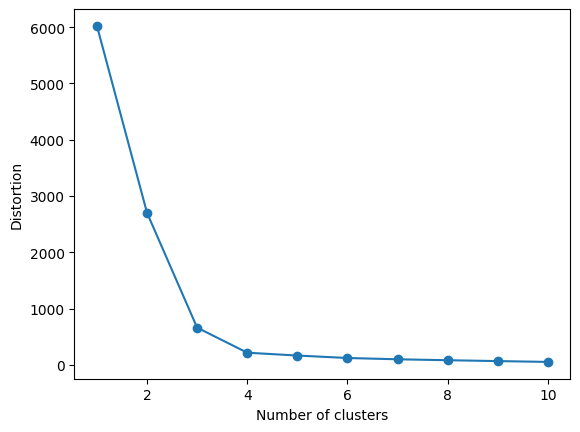

In [15]:
from sklearn.cluster import KMeans

WCSS = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, n_init=50, max_iter=500, random_state=0,init = 'k-means++')
    km.fit(embeddings_2d )
    WCSS.append(km.inertia_)

# plot
plt.plot(range(1, 11), WCSS, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show() # Based on elbow method, k should be 3.

We now cluster the teams embeddings on its original 200-dimensional space:

In [16]:
from ampligraph.discovery import find_clusters

clustering_algorithm = KMeans(n_clusters=3, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(symptoms, model, clustering_algorithm, mode='e')

print(len(clusters))
print(len(symptoms))

1926
1926


Store the clusters for later use

In [17]:
# Cluster-patient dictionary

results = dict(zip(clusters, symptoms))

with open("clusters_entities.txt", 'w') as f: 
    for key, value in results.items(): 
        f.write('%s:%s\n' % (key, value))

Visualization

In [18]:
plot_df = pd.DataFrame({"symptoms": symptoms, 
                        "embedding1": embeddings_2d[:, 0], 
                        "embedding2": embeddings_2d[:, 1],
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})

In [19]:
# Plot 2D embeddings
def plot_clusters(hue):
    plt.figure(figsize=(12, 12))
    plt.title("{} embeddings".format(hue).capitalize())
    ax = sns.scatterplot(data=plot_df,
                         x="embedding1", y="embedding2", hue=hue)

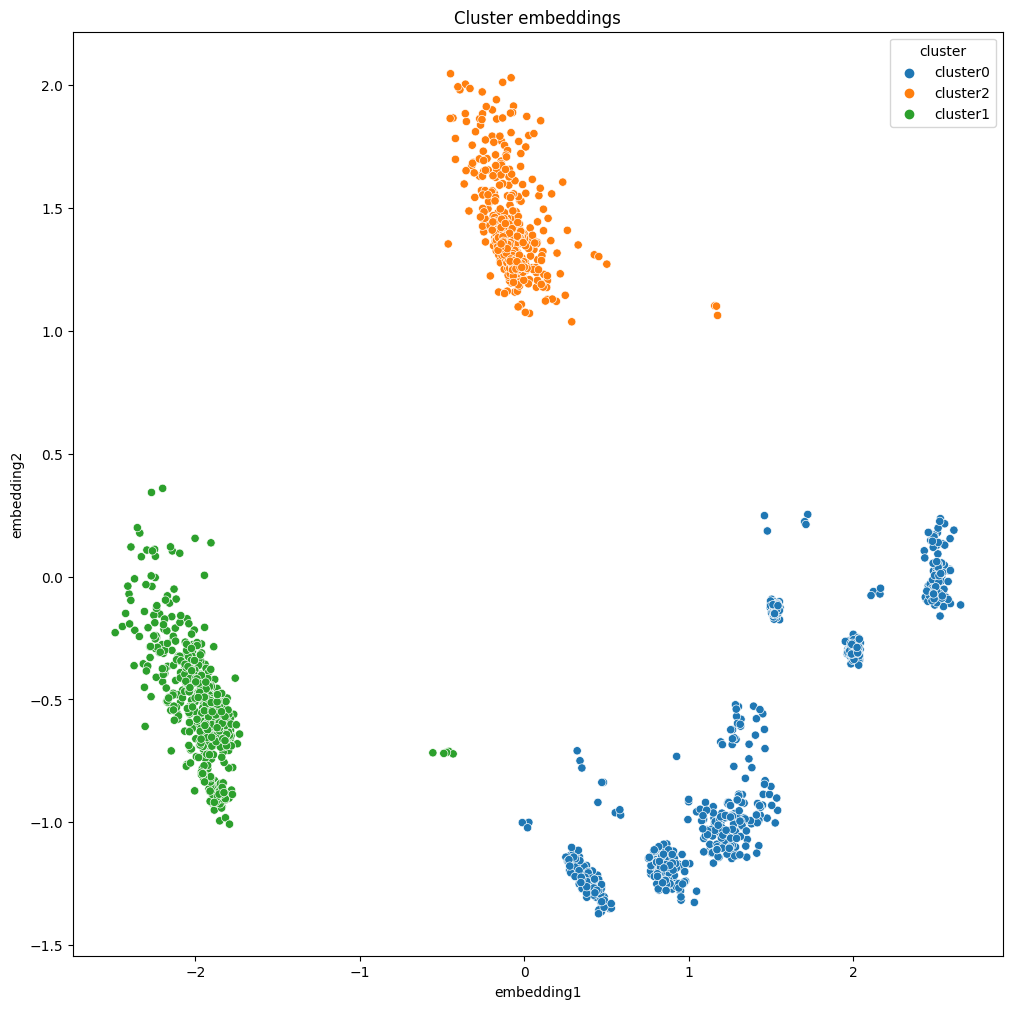

In [20]:
plot_clusters("cluster")